# Sample Model Pipeline

The following is example code to build a dataset for a classification model to predict a patient's race from screening mammograms. We'll be using the 'patient_race' feature we created in the 'dataset_filtering' notebook. For this example, images from Black patients will be considered the positive class while images from white patients will be considered the negative class.

This process will have the following stages:
1. [Define the clinical dataframe in Magview](#section_1)
2. [Merge the clinical dataframe with the image metadata](#section_2)
3. [Split the dataframes into train/val/test](#section_3)
4. [Convert the image paths and labels to a Tensorflow dataset](#section_4)
5. [Define and compile the model](#section_5)
6. [Train/evaluate the model](#section_6)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import tableone
from tqdm import tqdm
import tensorflow as tf
import os
import random
import itertools

# this line can be used to select which gpus to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2023-08-17 23:14:14.277185: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
/home/jupyter-tbrow51/.conda/envs/tf_old/lib/python3.8/site-packages/tensorflow/python/autograph/impl/api.py:22: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [2]:
# ensure the gpu/s are recognized by tensorflow
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-08-17 23:14:22.650726: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-08-17 23:14:22.701698: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2023-08-17 23:14:22.701759: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-08-17 23:14:22.706230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-08-17 23:14:22.706362: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2023-08-17 23:14:22.707476: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10

---
<a id="section_1"></a>
### 1. Define the clinical dataframe in Magview

In [3]:
def dataframe_stats(df, title: str or None = None):
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")

In [4]:
# FOR TESTING
base_directory = "/data/beatrice/emory_datathon/embed_upload"
mag_path = base_directory + "/tables/embed_datathon_magview_reduced.csv"
meta_path = base_directory + "/tables/embed_datathon_metadata_full.csv"

# mag_path = "/embed/tables/embed_datathon_magview_reduced.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
dataframe_stats(mag_df, 'Magview')

/tmp/ipykernel_40576/4198159187.py:9: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  mag_df = pd.read_csv(mag_path)



Magview
Patients: 115883
Exams: 364733


In [10]:
# # create the 'patient_race' column and set the default value to 'Unknown'
# mag_df.loc[:, 'patient_race'] = 'Unknown'

# # code races for Black and white patients
# mag_df.loc[mag_df['ETHNICITY_DESC'] == 'African American or Black', 'patient_race'] = 'Black'
# mag_df.loc[mag_df['ETHNICITY_DESC'] == 'Caucasian or White', 'patient_race'] = 'White'

# # consolidate other patient race categories
# other_race_categories = [
#     'American Indian or Alaskan Native', 
#     'Asian', 
#     'Hispanic', 
#     'Multiple', 
#     'Native Hawaiian or Other Pacific Islander'
# ]
# mag_df.loc[mag_df['ETHNICITY_DESC'].isin(other_race_categories), 'patient_race'] = 'Other'

In [40]:
# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# get dataframe of screening exams for patients with breast density A
mag_scr_dense_A_df = mag_scr_df[mag_scr_df['tissueden'] == 1.0]
dataframe_stats(mag_scr_dense_A_df, 'mag_scr_dense_A_df')

# get dataframe of screening exams for patients with breast density A
mag_scr_dense_B_df = mag_scr_df[mag_scr_df['tissueden'] == 2.0]
dataframe_stats(mag_scr_dense_B_df, 'mag_scr_dense_B_df')

# get dataframe of screening exams for patients with breast density A
mag_scr_dense_C_df = mag_scr_df[mag_scr_df['tissueden'] == 3.0]
dataframe_stats(mag_scr_dense_C_df, 'mag_scr_dense_C_df')

# get dataframe of screening exams for patients with breast density A
mag_scr_dense_D_df = mag_scr_df[mag_scr_df['tissueden'] == 4.0]
dataframe_stats(mag_scr_dense_D_df, 'mag_scr_dense_D_df')


mag_scr_dense_A_df
Patients: 12154
Exams: 29689

mag_scr_dense_B_df
Patients: 47002
Exams: 119613

mag_scr_dense_C_df
Patients: 46422
Exams: 117041

mag_scr_dense_D_df
Patients: 6377
Exams: 14301


In [42]:
def balance_id_sets(id_set_list):
    for i, (set_a, set_b) in enumerate(itertools.combinations(id_set_list, 2)):
        intersections = set_a.intersection(set_b)
        for num in intersections:
            if len(set_a) < len(set_b):
                set_b.discard(num)
            else:
                set_a.discard(num)
            break
    return id_set_list

# get sets of unique patient ids in each df
setA = set(mag_scr_dense_A_df.empi_anon)
setB = set(mag_scr_dense_B_df.empi_anon)
setC = set(mag_scr_dense_C_df.empi_anon)
setD = set(mag_scr_dense_D_df.empi_anon)

print('Before balancing:')
print('\tPatient IDs in A:', len(setA))
print('\tPatient IDs in B:', len(setB))
print('\tPatient IDs in C:', len(setC))
print('\tPatient IDs in D:', len(setD))

# balance sets to ensure unique patients in each dataframe
sets = balance_id_sets([setA, setB, setC, setD])
            
print('\nAfter balancing:')
print('\tPatient IDs in A:', len(setA))
print('\tPatient IDs in B:', len(setB))
print('\tPatient IDs in C:', len(setC))
print('\tPatient IDs in D:', len(setD))

Before balancing:
	Patient IDs in A: 12154
	Patient IDs in B: 47002
	Patient IDs in C: 46422
	Patient IDs in D: 6377

After balancing:
	Patient IDs in A: 12154
	Patient IDs in B: 46999
	Patient IDs in C: 46420
	Patient IDs in D: 6377


In [43]:
# filter patients to ensure there is no data leakage
mag_scr_dense_A_df = mag_scr_dense_A_df[mag_scr_dense_A_df['empi_anon'].isin(setA)]
mag_scr_dense_B_df = mag_scr_dense_B_df[mag_scr_dense_B_df['empi_anon'].isin(setB)]
mag_scr_dense_C_df = mag_scr_dense_C_df[mag_scr_dense_C_df['empi_anon'].isin(setC)]
mag_scr_dense_D_df = mag_scr_dense_D_df[mag_scr_dense_D_df['empi_anon'].isin(setD)]

dataframe_stats(mag_scr_dense_A_df, 'mag_scr_dense_A_df (filtered)')
dataframe_stats(mag_scr_dense_B_df, 'mag_scr_dense_B_df (filtered)')
dataframe_stats(mag_scr_dense_C_df, 'mag_scr_dense_C_df (filtered)')
dataframe_stats(mag_scr_dense_D_df, 'mag_scr_dense_D_df (filtered)')


mag_scr_dense_A_df (filtered)
Patients: 12154
Exams: 29689

mag_scr_dense_B_df (filtered)
Patients: 46999
Exams: 119608

mag_scr_dense_C_df (filtered)
Patients: 46420
Exams: 117037

mag_scr_dense_D_df (filtered)
Patients: 6377
Exams: 14301


---
<a id="section_2"></a>
### 2. Merge the clinical dataframe with the image metadata

In [44]:
# meta_path = "/embed/tables/embed_datathon_metadata_reduced.csv"

# load image metadata
meta_df = pd.read_csv(meta_path)
dataframe_stats(meta_df, 'Metadata')

/tmp/ipykernel_40576/1458441627.py:4: DtypeWarning: Columns (74,103,104,113,114,115,116,117,118,119,121,128,130,131,132,133,134,136,141,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv(meta_path)



Metadata
Patients: 115894
Exams: 364733
Images: 2403687


In [45]:
# define a list of columns from meta_df to retain
meta_cols = ['acc_anon', 'ImageLateralityFinal', 'png_path']

# filter the dataframe to only contain 2D images
meta_2d_df = meta_df[meta_df.FinalImageType == '2D']

# merge magview positive and negative dataframes with metadata
meta_2d_scr_dense_A_df = mag_scr_dense_A_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_dense_A_df, 'mag_scr_dense_A_df')
dataframe_stats(meta_2d_scr_dense_A_df, 'meta_2d_scr_dense_A_df (merged)')

meta_2d_scr_dense_B_df = mag_scr_dense_B_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_dense_B_df, '\nmag_scr_dense_B_df')
dataframe_stats(meta_2d_scr_dense_B_df, 'meta_2d_scr_dense_B_df (merged)')

meta_2d_scr_dense_C_df = mag_scr_dense_C_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_dense_C_df, '\nmag_scr_dense_C_df')
dataframe_stats(meta_2d_scr_dense_C_df, 'meta_2d_scr_dense_C_df (merged)')

meta_2d_scr_dense_D_df = mag_scr_dense_D_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_dense_D_df, '\nmag_scr_dense_D_df')
dataframe_stats(meta_2d_scr_dense_D_df, 'meta_2d_scr_dense_D_df (merged)')


mag_scr_dense_A_df
Patients: 12154
Exams: 29689

meta_2d_scr_dense_A_df (merged)
Patients: 3602
Exams: 5340
Images: 17121


mag_scr_dense_B_df
Patients: 46999
Exams: 119608

meta_2d_scr_dense_B_df (merged)
Patients: 19199
Exams: 30498
Images: 92913


mag_scr_dense_C_df
Patients: 46420
Exams: 117037

meta_2d_scr_dense_C_df (merged)
Patients: 20784
Exams: 31643
Images: 95846


mag_scr_dense_D_df
Patients: 6377
Exams: 14301

meta_2d_scr_dense_D_df (merged)
Patients: 2295
Exams: 3161
Images: 9663


<div class="alert alert-block alert-warning">
<b>Warning:</b> A large number of exams were lost in the above step. For exams with no findings (generally BIRADS 1 or 2), 'side' is often left empty as the field is populated for findings. This can be solved by only merging on 'acc_anon' and then filtering by side. E.g. disinclude images where side == 'L' and 'ImageLateralityFinal' == 'R', but retain any corresponding images when side == '' or 'B'.
</div>

| Side | ImageLateralityFinal | Keep? |
| :-: | :-: | :-: |
| "L" | "L" | $\color{green}{\text{True}}$
| "L" | "R" | $\color{red}{\text{False}}$
| "R" | "R" | $\color{green}{\text{True}}$
| "R" | "L" | $\color{red}{\text{False}}$
| " " | "R" | $\color{green}{\text{True}}$
| " " | "L" | $\color{green}{\text{True}}$
| "B" | "R" | $\color{green}{\text{True}}$
| "B" | "L" | $\color{green}{\text{True}}$

<div class="alert alert-block alert-info">
<b>Note:</b> We'll take a random sample of the positive and negative dataframes to speed up testing but classes should be balanced (or left unaltered) as desired.
</div>

In [46]:
n = 2_500
seed = 13
meta_2d_scr_dense_A_sample_df = meta_2d_scr_dense_A_df.sample(n, random_state=seed)
meta_2d_scr_dense_B_sample_df = meta_2d_scr_dense_B_df.sample(n, random_state=seed)
meta_2d_scr_dense_C_sample_df = meta_2d_scr_dense_C_df.sample(n, random_state=seed)
meta_2d_scr_dense_D_sample_df = meta_2d_scr_dense_D_df.sample(n, random_state=seed)

dataframe_stats(meta_2d_scr_dense_A_sample_df, 'meta_2d_scr_dense_A_sample_df')
dataframe_stats(meta_2d_scr_dense_B_sample_df, 'meta_2d_scr_dense_B_sample_df')
dataframe_stats(meta_2d_scr_dense_C_sample_df, 'meta_2d_scr_dense_C_sample_df')
dataframe_stats(meta_2d_scr_dense_D_sample_df, 'meta_2d_scr_dense_D_sample_df')


meta_2d_scr_dense_A_sample_df
Patients: 1659
Exams: 1995
Images: 2500

meta_2d_scr_dense_B_sample_df
Patients: 2258
Exams: 2408
Images: 2500

meta_2d_scr_dense_C_sample_df
Patients: 2286
Exams: 2417
Images: 2500

meta_2d_scr_dense_D_sample_df
Patients: 1437
Exams: 1764
Images: 2500


---
<a id="section_3"></a>
### 3. Split the dataframes into train/val/test

In [60]:
# function to get the set of unique patient ids in the dataframe
# then split based on the train/val/test proportion
def split_ids(id_col, train_prop, seed):
    # get set of unique ids and convert to a list
    id_list = list(set(id_col))
    
    # shuffle id list
    random.Random(seed).shuffle(id_list)
    
    # get split lengths
    id_list_len = len(id_list)
    train_len = int(id_list_len * train_prop)
    test_len = (id_list_len - train_len) // 2
    
    # index set ids
    train_ids = id_list[:train_len]
    val_ids = id_list[train_len:train_len+test_len]
    test_ids = id_list[train_len+test_len:]
    
    print('total ids:', id_list_len)
    print('train ids: {}, prop: {:.3f}'.format(len(train_ids), 
                                               len(train_ids) / id_list_len))
    print('val ids: {}, prop: {:.3f}'.format(len(val_ids), 
                                             len(val_ids) / id_list_len))
    print('test ids: {}, prop: {:.3f}\n'.format(len(test_ids), 
                                              len(test_ids) / id_list_len))
    return train_ids, val_ids, test_ids
    
# function to index pos/neg dataframes by set patient ids and merge them
def index_dataframes(dfs, ids, id_var):
    # zip pos/neg dataframes and ids
    components = zip(dfs, ids)
    
    # index dataframes by ids for pos/neg
    df_list = [df[df[id_var].isin(ids)] for df, ids in components]
    
    # merge pos/neg dataframes
    out_df = pd.concat(df_list, axis=0)
    return out_df

# function to split a positive and negative dataframe into train/val/test 
# then merge positive and negative for each
def split_n_dataframes(df_list, id_var: str = 'empi_anon', 
                       train_prop: float = 0.6, seed: int = 13):
    # add label columns to dataframes
    for df in df_list:
        df['label'] = df['tissueden']
    
    # get empty list to put dataframe set IDs
    df_ids = []
    
    # get ids for each split dataframe
    for df in df_list:
        train_ids, val_ids, test_ids = split_ids(
            df[id_var], 
            train_prop, 
            seed
        )
        df_ids.append([train_ids, val_ids, test_ids])
    
    # transpose list to get sublists of all train set IDs, val sets IDs, etc.
    trans_df_ids = [i for i in zip(*df_ids)]

    # prepare lists for indexing
    train_ids = trans_df_ids[0]
    val_ids = trans_df_ids[1]
    test_ids = trans_df_ids[2]
    
    # index split dataframes
    train_df = index_dataframes(df_list, train_ids, id_var)
    val_df = index_dataframes(df_list, val_ids, id_var)
    test_df = index_dataframes(df_list, test_ids, id_var)
    
    # shuffle dataframes
    train_df = train_df.sample(frac=1, random_state=seed)
    val_df = val_df.sample(frac=1, random_state=seed)
    test_df = test_df.sample(frac=1, random_state=seed)
    
    return train_df.reset_index(), val_df.reset_index(), test_df.reset_index()

In [61]:
# dataframes need to be split along 'empi_anon' to prevent data leakage between train/val/test
df_list = [
    meta_2d_scr_dense_A_sample_df, 
    meta_2d_scr_dense_B_sample_df, 
    meta_2d_scr_dense_C_sample_df, 
    meta_2d_scr_dense_D_sample_df
]

train_df, val_df, test_df = split_n_dataframes(df_list)

total ids: 1659
train ids: 995, prop: 0.600
val ids: 332, prop: 0.200
test ids: 332, prop: 0.200

total ids: 2258
train ids: 1354, prop: 0.600
val ids: 452, prop: 0.200
test ids: 452, prop: 0.200

total ids: 2286
train ids: 1371, prop: 0.600
val ids: 457, prop: 0.200
test ids: 458, prop: 0.200

total ids: 1437
train ids: 862, prop: 0.600
val ids: 287, prop: 0.200
test ids: 288, prop: 0.200



Let's check our dataframe stats and split to make sure it's been defined correctly.

In [62]:
dataframe_stats(train_df, 'train')
dataframe_stats(val_df, 'validation')
dataframe_stats(test_df, 'test')


train
Patients: 4563
Exams: 5133
Images: 5930

validation
Patients: 1527
Exams: 1716
Images: 2050

test
Patients: 1527
Exams: 1735
Images: 2020


In [63]:
tableone(train_df, ['tissueden'], groupby=['label'])

Grouped by label                                                                     
                              Missing      Overall           1.0           2.0           3.0           4.0
n                                             5930          1486          1494          1500          1450
tissueden, n (%) 1.0                0  1486 (25.1)  1486 (100.0)                                          
                 2.0                   1494 (25.2)                1494 (100.0)                            
                 3.0                   1500 (25.3)                              1500 (100.0)              
                 4.0                   1450 (24.5)                                            1450 (100.0)

In [64]:
tableone(val_df, ['tissueden'], groupby=['label'])

Grouped by label                                                                
                              Missing     Overall          1.0          2.0          3.0          4.0
n                                            2050          498          507          499          546
tissueden, n (%) 1.0                0  498 (24.3)  498 (100.0)                                       
                 2.0                   507 (24.7)               507 (100.0)                          
                 3.0                   499 (24.3)                            499 (100.0)             
                 4.0                   546 (26.6)                                         546 (100.0)

In [65]:
tableone(test_df, ['tissueden'], groupby=['label'])

Grouped by label                                                                
                              Missing     Overall          1.0          2.0          3.0          4.0
n                                            2020          516          499          501          504
tissueden, n (%) 1.0                0  516 (25.5)  516 (100.0)                                       
                 2.0                   499 (24.7)               499 (100.0)                          
                 3.0                   501 (24.8)                            501 (100.0)             
                 4.0                   504 (25.0)                                         504 (100.0)

---
<a id="section_4"></a>
### 4. Convert the image paths and labels to a Tensorflow dataset

In [79]:
def load_imgs(img_path, label, channels: int = 3):
    """
    loads images from img paths in a tensor and returns images and labels
    """
    # read the file's content
    img_data = tf.io.read_file(img_path)
    
    # decode the image and set it to float dtype
    # limiting channels to 1 is more efficient, but it would disallow
    # the use of pretrained weights from sources like imagenet
    img = tf.image.decode_image(img_data, channels=channels, dtype=tf.float32)
    
    return img, label

def encode_label(label, num_classes: int = 4):
    # convert label from ordinal to one-hot encoding
    return [1.0 if (i + 1) == label else 0.0 for i in range(4)]

def img_preprocessing(img, label, img_shape = (800, 600)):
    """
    preprocessing function to resize images and normalize values
    """
    assert len(img_shape) == 2, 'img_shape should contain the desired (height, width)'
    
    # set approximate img tensor shape to allow flexible processing
    img.set_shape([None, None, 3])
    
    # resize images to img_shape
    img = tf.image.resize(img, img_shape)
    
    # normalize image between -1 and 1
    min_val = tf.reduce_min(img)
    max_val = tf.reduce_max(img)
    img = 2 * (img - min_val) / (max_val - min_val) - 1
    
    # convert label to one-hot encoding
    label = encode_label(label)
    
    return img, label


def build_dataset(df, img_col: str = 'png_path', label_col: str = 'label'):
    """
    converts a dataframe to a tensor of png paths and labels then maps 
    the paths to images and applies the desired preprocessing
    """
    # to build our dataset, we first need to separate our image 
    # paths and labels and convert them to numpy arrays
    paths = np.array(df[img_col])
    labels = np.array(df[label_col]).astype(np.float32)

    # next, we use 'from_tensor_slices' to convert these arrays to a tensor
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    
    # map the image paths to images
    ds = ds.map(load_imgs)
    
    # perform any necessary image preprocessing
    ds = ds.map(img_preprocessing)
    return ds


# let's convert our dataframes to tensorflow datasets
train_ds = build_dataset(train_df)
val_ds = build_dataset(val_df)
test_ds = build_dataset(test_df)

train
max: 1.0
min: -1.0
label: [0. 1. 0. 0.]


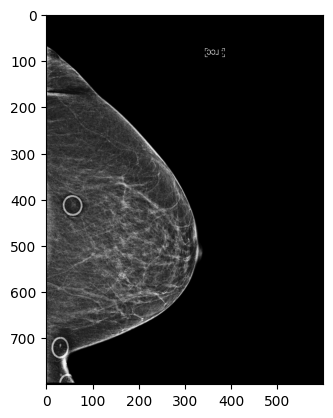

max: 1.0
min: -1.0
label: [0. 0. 1. 0.]


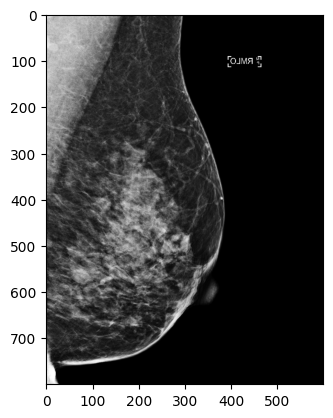

max: 1.0
min: -1.0
label: [0. 1. 0. 0.]


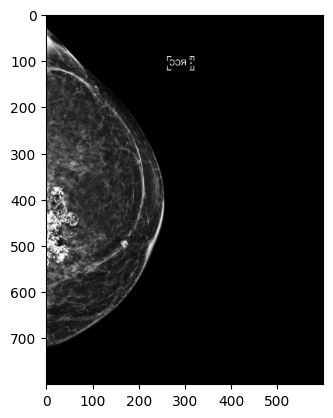

max: 1.0
min: -1.0
label: [0. 0. 1. 0.]


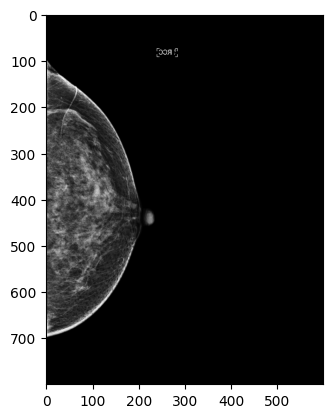

max: 1.0
min: -1.0
label: [0. 0. 1. 0.]


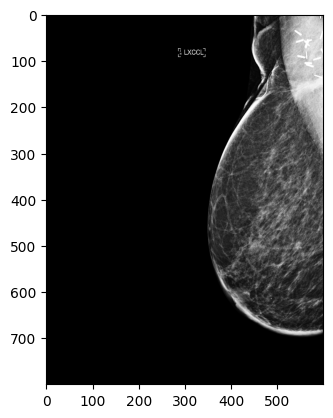

val
max: 1.0
min: -1.0
label: [1. 0. 0. 0.]


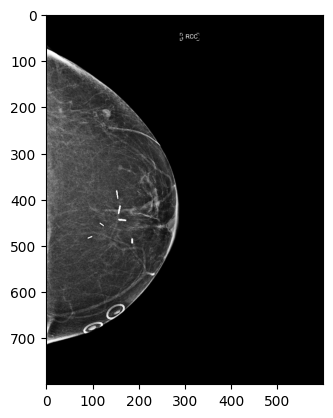

max: 1.0
min: -1.0
label: [0. 0. 1. 0.]


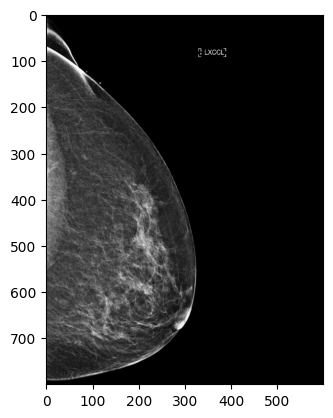

max: 1.0
min: -1.0
label: [0. 0. 1. 0.]


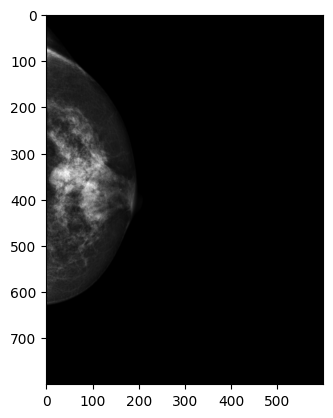

max: 1.0
min: -1.0
label: [0. 0. 0. 1.]


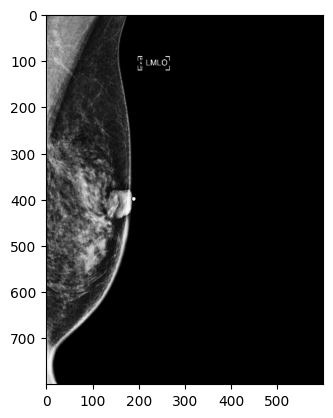

max: 1.0
min: -1.0
label: [0. 0. 0. 1.]


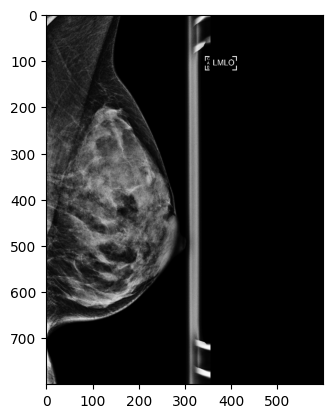

test
max: 1.0
min: -1.0
label: [1. 0. 0. 0.]


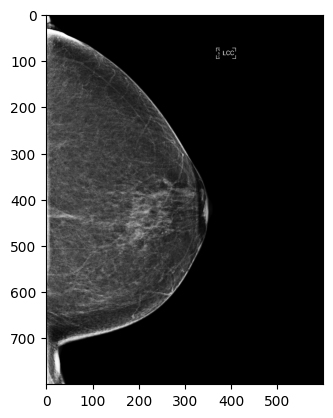

max: 1.0
min: -1.0
label: [0. 0. 0. 1.]


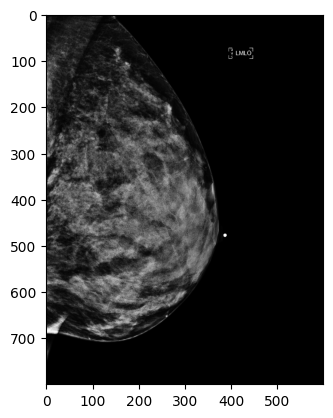

max: 1.0
min: -1.0
label: [0. 1. 0. 0.]


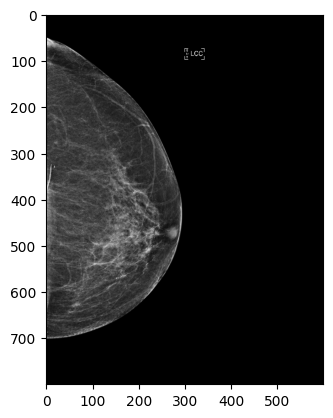

max: 1.0
min: -1.0
label: [1. 0. 0. 0.]


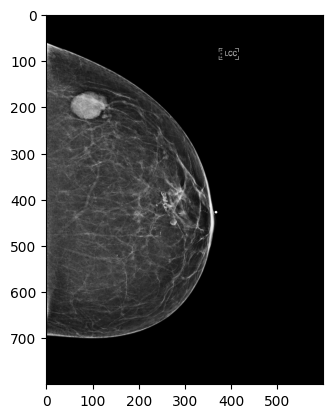

max: 1.0
min: -1.0
label: [1. 0. 0. 0.]


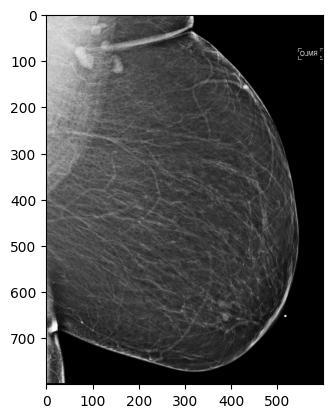

In [80]:
# let's visualize our datasets to make sure the images have been loaded correctly

def undo_img_preproc(img):
    img += 1.0
    img /= 2.0
    return img

dss = [train_ds.take(5), val_ds.take(5), test_ds.take(5)]
ds_names = ['train', 'val', 'test']

for ds, ds_name in zip(dss, ds_names):
    print(ds_name)
    for img, label in ds:
        img = np.array(img)
        # img = cv.imread(data.png_path)
        print('max:', img.max())
        print('min:', img.min())
        print('label:', label.numpy())
        plt.imshow(undo_img_preproc(img))
        plt.show()

In [81]:
batch_size = 20

# let's convert our dataframes to tensorflow datasets
train_bds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_bds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_bds = test_ds.batch(batch_size)

---
<a id="section_5"></a>
### 5. Define and compile the model

In [83]:
learning_rate = 0.0005
img_dims = (800, 600, 3)

def resnet_model(img_dims, num_classes):
    """
    builds a ResNet50V2 model with the keras functional api
    """
    # define the model input
    inputs = tf.keras.layers.Input(img_dims)
    
    # define the ResNet50V2 model core
    # we're importing imagenet weights (even though we're working on a very different domain)
    # this is optional but in some cases it can help achieve a reasonable initialization
    x = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights=None,
        input_shape=img_dims,
        classifier_activation=None,
    )(inputs)

    # define classifier architecture
    x = tf.keras.layers.Conv2D(num_classes, kernel_size=(3, 3))(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # apply a sigmoid activation since our model is for binary classification
    outputs = tf.nn.softmax(x)
    
    # build the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def add_regularizer(model, regularizer, verbose: bool = False):
    """
    adds a regularizer to all nested conv and dw conv layers in a model
    """
    # iterate over layers in the model
    for layer in model.layers:
        # if the layer has nested layers, recursively call the function
        if hasattr(layer, 'layers'):
            add_regularizer(layer, regularizer, verbose)
            
        # else, if the layer is a DepthwiseConv2D add the regularizer to depthwise_kernel
        elif isinstance(layer, tf.keras.layers.DepthwiseConv2D):
            if verbose:
                print(f'regularizer added to layer {layer.name}')
            layer.add_loss(lambda x=layer.depthwise_kernel: regularizer(x))

        # else, if the layer is a Conv2D add the regularizer to kernel
        elif isinstance(layer, tf.keras.layers.Conv2D):
            if verbose:
                print(f'regularizer added to layer {layer.name}')
            layer.add_loss(lambda x=layer.kernel: regularizer(x))
            
def update_momentum(model, new_momentum, verbose: bool = False):
    """
    updates the momentum for all batch norm layers in a model.
    this isn't 100% necessary but can fix a bug that sometimes 
    occurs when loading models from keras where batch norm 
    layers don't work correctly during inference. 
    """
    # iterate over layers in the model
    for layer in model.layers:
        # if the layer has nested layers, recursively call the function
        if hasattr(layer, 'layers'):
            update_momentum(layer, new_momentum, verbose)
            
        # else, if the layer is a BatchNormalization update the momentum to new_momentum
        elif isinstance(layer, tf.keras.layers.BatchNormalization):
            if verbose:
                print(f"momentum updated from '{layer.momentum}' to '{new_momentum}' for layer {layer.name}")
            layer.momentum = new_momentum

# compile model
model = resnet_model(img_dims, 4)

# update model momentum
update_momentum(model, 0.9, True)

# add l2 regularization to all nested layers in the model
# regularizer = tf.keras.regularizers.l1()
# add_regularizer(model, regularizer, True)

# define our model evaluation metrics
model_metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy')
]

# compile our model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
    loss=tf.keras.losses.CategoricalCrossentropy(), 
    metrics=model_metrics
)

# build the model so we can view a summary of its architecture
model.build((None,) + img_dims)
model.summary()

momentum updated from '0.99' to '0.9' for layer conv2_block1_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block1_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block1_2_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block2_2_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_preact_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_1_bn
momentum updated from '0.99' to '0.9' for layer conv2_block3_2_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_preact_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_1_bn
momentum updated from '0.99' to '0.9' for layer conv3_block1_2_bn
momentum updated from '0.99' to '0.9' for layer conv3_block2_preact_bn
momentum updated from '0.99' to '0.9' for layer conv3_block2_1_bn
momentum updated from '0.99' to '0.9' for layer con

---
<a id="section_6"></a>
### 6. Train/evaluate the model.

Now that our model is defined and our dataset is prepared, we can train and evaluate its performance.

In [84]:
num_epochs = 10

model.fit(train_bds, epochs=num_epochs, validation_data=val_bds)

Epoch 1/10


2023-08-18 00:23:26.402163: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2023-08-18 00:23:38.077468: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8100
2023-08-18 00:23:40.635645: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-08-18 00:23:41.462531: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


 25/297 [=>............................] - ETA: 5:02 - loss: 1.4276 - accuracy: 0.3960

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_bds)